# Import Modules

In [0]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.python.platform import gfile
import matplotlib.pyplot as plt
from scipy import misc
import progressbar

%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 6.0)

In [2]:
!pip install progressbar2

# Connecting with Google Drive

Using standard code to connect this colaboratory notebook to the Google Drive where all our data is

In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

Run this cell **only once**. This will mount your Google Drive disk. 

In [0]:
## You should only run this cell once!
!mkdir -p drive
!google-drive-ocamlfuse drive

Run this cell if you want to **update** your driver image disk. This will chear the cache and get the new image of your Google Drive.

In [11]:
!google-drive-ocamlfuse -cc

Clearing cache...done


Changing the directory to the project folder.

In [6]:
os.chdir('drive/FaceRecognition')
!ls

data		  get_embeddings.ipynb	 README.md	   test.npy
datasets	  models		 requirements.txt  validate-model.ipynb
face-recognition  Peter_Mackay_0001.npy  src


# Loading the model

Start loading the Facenet [pre-trained model](https://github.com/davidsandberg/facenet) chosen.

We are using **TensorFlow** version 1.10.1 on this notebook, and loading the model trained with the VGGFace2 dataset using the network architecture **Inception ResNet v1**. 

| Models                      | LFW accuracy    | Training Dataset                | Architecture                |
| ------------------------------- | :------------------------: | --------------------------------------: | --------------------------------: |
| 20180408-102900   | 0.9905                 | CASIA-WebFace               | Inception ResNet v1 |
| 20180402-114759   | 0.9965                 | VGGFace2                         | Inception ResNet v1 |


Working directory set to be the model directory.

In [0]:
def get_filenames(filepath):
  list_files = os.listdir(filepath)
  for filename in list_files:
    if filename.endswith('meta'):
      model_file = filename
    elif filename.endswith('index'):
      ckpt_file = filename.strip('.index')
      
  return model_file, ckpt_file

def load_model(filepath, input_map=None):
  if os.path.isfile(filepath):
    print('Loading files:')
    print('Model filename: %s\n' % filepath)
    with gfile.FastGFile(filepath, 'rb') as f:
      graph_def = tf.GraphDef()
      graph_def.ParseFromString(f.read())
      tf.import_graph_def(graph_def, input_map=input_map, name='')
    
  else:
    model_file, ckpt_file = get_filenames(filepath)
    curr_sess = tf.get_default_session()

    print('Loading files:')
    print('Model: %s' % model_file)
    print('Checkpoint: %s\n' % ckpt_file)

    saver = tf.train.import_meta_graph(os.path.join(filepath, model_file),
                                       input_map=input_map)
    saver.restore(curr_sess, os.path.join(filepath, ckpt_file))
    
  print('Succeeded!')

In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
model = load_model('models/facenet/20180402-114759/20180402-114759.pb')

Loading files:
Model filename: models/facenet/20180402-114759/20180402-114759.pb

Succeeded!


# Loading testing image

Loading a random test image from **LFW Dataset** (*Labeled Faces in the Wild*).

In [0]:
def get_random_image(dataset_path, plot=False):
  list_people = os.listdir(dataset_path)
  nrof_people = len(list_people)
  
  chosen_person = list_people[np.random.randint(nrof_people)]
  
  if dataset_path[-1] != '/':
    dataset_path += '/'
    
  list_images = os.listdir(dataset_path + chosen_person)
  random_image = list_images[np.random.randint(len(list_images))]
  image_path = dataset_path + chosen_person + '/' + random_image
  
  image = misc.imread(image_path)
  if plot:
    plt.imshow(image)
    plt.title(chosen_person)
    plt.axis('off')
  
  return image_path, image

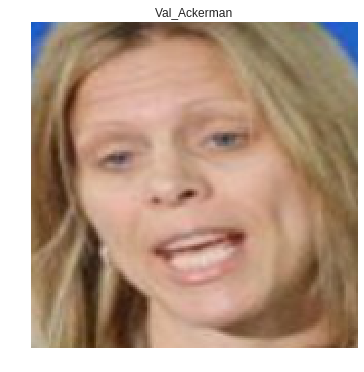

In [9]:
image_path, original_image = get_random_image('datasets/lfw/lfw_mtcnnpy_160/', plot=True)

# Embeddings

The main goal on this notebook is to perform forward propagation on all images on our [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) dataset, building a dataset with the embeddings that were outputed from the pre-trained ResNet v1. 

Those embeddings will be used to train a smaller model, trying to perform as close as possible as the ResNet accuracy. The smaller model will try to learn how an image is processed from the *raw pixels* to the *embeddings vector*, and therefore will use the embeddings output from the ResNet model.  

## Forward Propagation

First, we'll check how it's the procedure to perform forward propagation on only one image. To read the image, we'll use the scipy's `misc` function, and then we'll use the pre-trained model to get the embedding vector from the image. 

All the images on this notebook were pre processed using [Multi-task CNN](https://kpzhang93.github.io/MTCNN_face_detection_alignment/index.html) for detection and alignment of the faces using this [Python implementation](https://github.com/davidsandberg/facenet/tree/master/src/align).To avoid computational cost, there are no intention on doing such pre process on the real time images on Raspberry.

In [0]:
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))

In [0]:
images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")

In [0]:
embeddings_size = embeddings.get_shape()[1]

In [0]:
nrof_images = 1
images = original_image.reshape((nrof_images, *original_image.shape))

In [0]:
# Solved problem using the .pb model, and not the meta+ckpt
feed_dict = { images_placeholder: images, phase_train_placeholder: False }
embeddings_array = np.zeros((nrof_images, embeddings_size))
embeddings_array = sess.run(embeddings, feed_dict=feed_dict)

## Save on a `npy` file

Saving the embeddings array on a `npy` file. Numpy files are optimized to be faster to read or write than regular files. 

In [0]:
np.save('test.npy', embeddings_array)

Testing whether the embedding saved on the `npy` file is the same loaded from it.

In [0]:
emb = np.load('test.npy')

In [54]:
# The file saved is the same of the loaded one
~np.any(~np.equal(embeddings_array, emb))

True

# Processing data to distillation

The process of learning the knowledge from a bigger network is called **Network Distillation**, and is based on the Geoffrey Hinton's paper [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531). 

On this work, we'll train a supervised learning algorithm using the images from the [LFW dataset](http://vis-www.cs.umass.edu/lfw/) as input, and the embedding vectors from applying the bigger model's forward propagation on the input images as truth labels. The goal of this training is to learn how to extract the embedding features from the image as well as the state-of-the-art Facenet model.

To make the training procedure faster, the embedding vectors will be obtained  *a priori*. The output embeddings will be placed on an `output` directory inside the dataset's folder.

In [0]:
def process_image(path):
  original_image = misc.imread(path)
  image = original_image.reshape((1, *original_image.shape))
  
  return image

In [0]:
def forward_propagation(image, sess):
  images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
  embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
  phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
  
  # Get embeddings
  embeddings_size = embeddings.get_shape()[1]
  feed_dict = { images_placeholder: image, phase_train_placeholder: False }
  embeddings_array = np.zeros((1, embeddings_size))
  embeddings_array = sess.run(embeddings, feed_dict=feed_dict)
  
  return embeddings_array

In [0]:
def get_image_paths(path, picture):
  image_path = os.path.join(path, picture)
  imagename = image_path.split('/')[-1].split('.')[0]
  
  output = os.path.join(path, 'output')
  output = os.path.join(output, imagename + '.npy')
  
  return image_path, output

In [14]:
base_path = 'datasets/lfw/lfw_mtcnnpy_160/'
people = os.listdir(base_path)

for person in progressbar.progressbar(people):
  # Get list of pictures of current person
  curr_path = os.path.join(base_path, person)
  
  # Check if the path is directory, if not, continue to next person
  if not os.path.isdir(curr_path):
    continue
  
  pictures = os.listdir(curr_path)
  
  # Fixing a bug
  bug_file = os.path.join(curr_path, 'output')
  bug_file = os.path.join(bug_file, person + '.npy')
  if os.path.isfile(bug_file):
    os.remove(bug_file)
  
  # Creating the folder
  output_path = curr_path + '/output'
  if not os.path.isdir(output_path):
    os.mkdir(output_path)
  
  for picture in pictures:
    # Reading the image & applying forward propagation
    curr_imagepath, output_filename = get_image_paths(curr_path, picture)

    # Check if the image is a file, not a dir
    if not os.path.isfile(curr_imagepath):
      continue
      -
    # Check if the image has already been processed
    if os.path.isfile(output_filename):
      continue
    
    image = process_image(curr_imagepath)
    curr_embeddings = forward_propagation(image, sess)
    
    # Saving the model
    np.save(output_filename, curr_embeddings)

100% (5753 of 5753) |####################| Elapsed Time: 6:31:18 Time:  6:31:18
